### Initial thoughts
- The AOV is very high which means that there are likely outliers present in the dataset
- 'mean' calculations are greatly affected by outliers 
- After exploring the data, I can examine outliers using a model for anomaly detection

In [1]:
import pandas as pd  
import numpy as np 
import seaborn as sns

### Read in the data and check it's format for useability
- check the variable types 
- check for any missing data

In [11]:
shoe_orders_df = pd.read_csv('q1_data_set.csv')
shoe_orders_df.head()

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
0,1,53,746,224,2,cash,2017-03-13 12:36:56
1,2,92,925,90,1,cash,2017-03-03 17:38:52
2,3,44,861,144,1,cash,2017-03-14 4:23:56
3,4,18,935,156,1,credit_card,2017-03-26 12:43:37
4,5,18,883,156,1,credit_card,2017-03-01 4:35:11


In [12]:
shoe_orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   order_id        5000 non-null   int64 
 1   shop_id         5000 non-null   int64 
 2   user_id         5000 non-null   int64 
 3   order_amount    5000 non-null   int64 
 4   total_items     5000 non-null   int64 
 5   payment_method  5000 non-null   object
 6   created_at      5000 non-null   object
dtypes: int64(5), object(2)
memory usage: 273.6+ KB


### Clean the data
- Before looking into anything, the data should be cleaned to avoid having to do this later on 
- Payment methods can be label/One Hot encoded (choose one hot encoding since payment methods are not ordinal data)
- Extract information from the created_at to have individual numerical features (easy to use later on)

In [13]:
shoe_orders_df['payment_method'].unique()

array(['cash', 'credit_card', 'debit'], dtype=object)

In [14]:
type(shoe_orders_df['created_at'][0])

str

In [15]:
from typing import List

def oh_encode(df: pd.DataFrame, cols: List[str] = ['payment_method'], drop: bool = False) -> pd.DataFrame:
    """ One hot encode a list of columns in a dataframe

    Args:
        df: The current dataframe in use
        cols: A list of column name to be one hot encoded 
        drop: True if the columns in the cols list should be dropped after OH encoding, otherwise false

    Returns:
        A new dataframe containing the one hot encoded columns
    """
    # make a copy of the df to avoid changing the original data  
    df = df.copy()
    for col in cols:
        # get OH encoded df and add concatenate it to the original df
        oh_col_df = pd.get_dummies(df[col])
        df = pd.concat([df, oh_col_df], axis=1)

    if drop:
        df.drop(columns=cols, inplace=True)
    
    return df

def extract_time(df: pd.DataFrame, col_name: str = 'created_at', drop: bool = True) -> pd.DataFrame:
    """ Extract date/time data from the created_at column

    Args: 
        df: The current dataframe in use
        col_name: The column to extract time data from
        drop: If true, drop the original time column 

    Returns: 
        A new dataframe containing new column with separate information about date and time
    """
    df = df.copy()

    datetime_col = pd.to_datetime(df[col_name])
    # extract date info 
    df['day'] = datetime_col.dt.day
    df['month'] = datetime_col.dt.month
    df['year'] = datetime_col.dt.year
    df['weekday'] = datetime_col.dt.dayofweek
    df['year_day'] = datetime_col.dt.dayofyear

    # extract time info; ignore the seconds (different in seconds sholud not matter for orders)
    df['hours_time'] = datetime_col.dt.hour + (datetime_col.dt.minute / 60)

    if drop:
        df.drop(columns=[col_name], inplace=True)

    return df

orders_df = oh_encode(shoe_orders_df)
orders_df = extract_time(orders_df)
orders_df.head()

,order_id,shop_id,user_id,order_amount,total_items,payment_method,cash,credit_card,debit,day,month,year,weekday,year_day,hours_time
0,1,53,746,224,2,cash,1,0,0,13,3,2017,0,72,12.600000
1,2,92,925,90,1,cash,1,0,0,3,3,2017,4,62,17.633333
2,3,44,861,144,1,cash,1,0,0,14,3,2017,1,73,4.383333
3,4,18,935,156,1,credit_card,0,1,0,26,3,2017,6,85,12.716667
4,5,18,883,156,1,credit_card,0,1,0,1,3,2017,2,60,4.583333


In [29]:
orders_df.shape

(5000, 15)

### EDA
- Perform some exploratory data analysis by drawing some graphs of the data
- Visualize the data to see anything that might point to a skewed monthly AOV

Text(0.5, 1.0, 'Order vs Price')

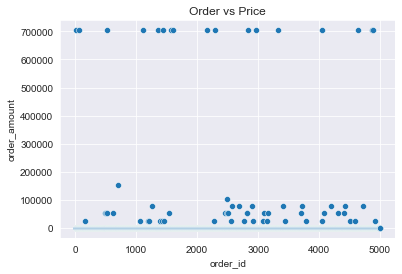

In [18]:
import seaborn as sns
sns.set_style('darkgrid')
# graph each order against order_amount to see how order order amount is distirbuted
price_by_order = sns.scatterplot(x='order_id', y='order_amount', data=orders_df)
price_by_order.set_title('Order vs Price')

- since there are many unique orders, examine the order total by shop id, user id and total items 
- When aggregating the data with mean aggregations in each of these 3 columns, factors affecting the AOV will start to become apparent

In [58]:
avg_cost_by_shop = orders_df.groupby('shop_id')['order_amount'].mean().sort_values(ascending=False)
avg_cost_by_user = orders_df.groupby('user_id')['order_amount'].mean().sort_values(ascending=False)
avg_cost_by_quantity = orders_df.groupby('total_items')['order_amount'].mean().sort_values(ascending=False)

In [59]:
avg_cost_by_shop.head(10)

shop_id
42    235101.490196
78     49213.043478
50       403.545455
90       403.224490
38       390.857143
81       384.000000
6        383.508475
89       379.147541
33       376.275000
51       361.804348
Name: order_amount, dtype: float64

In [60]:
avg_cost_by_user[avg_cost_by_user > 1000]

user_id
607    704000.000000
878     14266.909091
766      8007.600000
834      6019.000000
915      5785.142857
962      5743.428571
775      5069.625000
817      5061.750000
928      5041.750000
855      4759.705882
828      4670.750000
818      4341.315789
927      4187.923077
869      3930.500000
709      3923.357143
814      3909.071429
760      3757.733333
946      3681.200000
969      3663.869565
960      3492.312500
935      3479.312500
810      3462.750000
787      3428.280000
936      3118.722222
812      3091.888889
707      3087.222222
756      2707.818182
983      2672.619048
967      2672.285714
867      2619.090909
997      2248.923077
740      2145.571429
861      2145.428571
866      2121.571429
889      2114.142857
910      2060.600000
982      1819.823529
990      1676.578947
890      1669.947368
944      1597.900000
970      1572.450000
912      1519.350000
800      1519.238095
745      1408.500000
852      1399.260870
823      1298.583333
Name: order_amount, dtype:

In [61]:
avg_cost_by_user[avg_cost_by_user < 1000]

user_id
754    458.785714
926    420.916667
747    412.818182
702    406.615385
701    397.076923
          ...    
892    227.307692
899    226.666667
827    226.500000
939    219.600000
864    209.157895
Name: order_amount, Length: 255, dtype: float64

In [62]:
avg_cost_by_quantity.head(10)

total_items
2000    704000.000000
6        17940.000000
3         1191.076514
8         1064.000000
4          947.686007
5          759.350649
2          750.215066
1          417.364481
Name: order_amount, dtype: float64

Text(0.5, 1.0, 'Order vs Price by user')

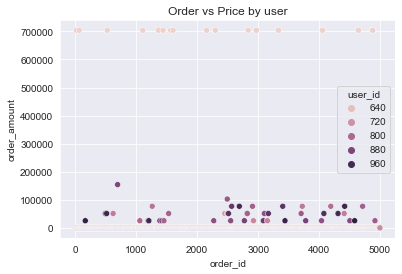

In [63]:

# same graph as the first one except with user_id as the hue
price_by_order = sns.scatterplot(x='order_id', y='order_amount', data=orders_df, hue='user_id')
price_by_order.set_title('Order vs Price by user')

In [64]:
orders_df.loc[orders_df['user_id'] == 607]

,order_id,shop_id,user_id,order_amount,total_items,payment_method,cash,credit_card,debit,day,month,year,weekday,year_day,hours_time
15,16,42,607,704000,2000,credit_card,0,1,0,7,3,2017,1,66,4.0
60,61,42,607,704000,2000,credit_card,0,1,0,4,3,2017,5,63,4.0
520,521,42,607,704000,2000,credit_card,0,1,0,2,3,2017,3,61,4.0
1104,1105,42,607,704000,2000,credit_card,0,1,0,24,3,2017,4,83,4.0
1362,1363,42,607,704000,2000,credit_card,0,1,0,15,3,2017,2,74,4.0
1436,1437,42,607,704000,2000,credit_card,0,1,0,11,3,2017,5,70,4.0
1562,1563,42,607,704000,2000,credit_card,0,1,0,19,3,2017,6,78,4.0
1602,1603,42,607,704000,2000,credit_card,0,1,0,17,3,2017,4,76,4.0
2153,2154,42,607,704000,2000,credit_card,0,1,0,12,3,2017,6,71,4.0
2297,2298,42,607,704000,2000,credit_card,0,1,0,7,3,2017,1,66,4.0


### Examine any time data 
- Since all the orders are made over a 30 day period, see if there is anything strange with amount of orders on certain days

Text(0.5, 0, 'Day of Year')

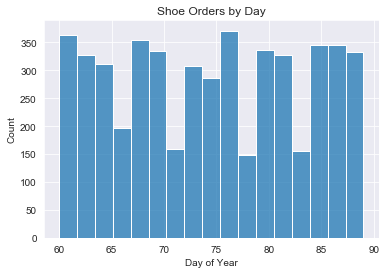

In [34]:
# we only have data made from 2017, see the amount of orders by month
orders_by_day = sns.histplot(x='year_day', data=orders_df)
orders_by_day.set_title('Shoe Orders by Day')
orders_by_day.set_xlabel('Day of Year')

Text(0.5, 1.0, 'Shoe orders by hour')

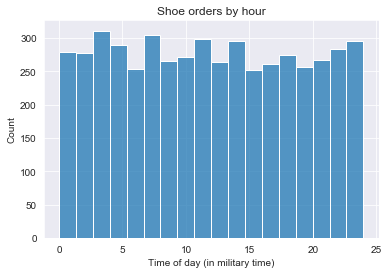

In [36]:
orders_by_hour = sns.histplot(x='hours_time', data=orders_df)
orders_by_hour.set_xlabel('Time of day (in military time)')
orders_by_hour.set_title('Shoe orders by hour')

### Examine payment methods
- See if any of the payment methods seemed off

Text(0.5, 1.0, 'Orders by Payment')

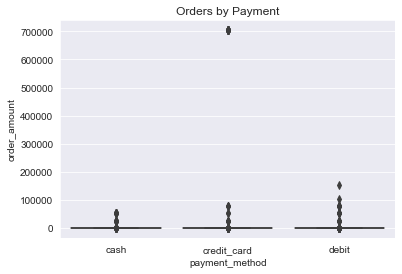

In [38]:
orders_by_payment = sns.boxplot(x='payment_method', y='order_amount', data=orders_df)
orders_by_payment.set_title('Orders by Payment')

### Users seem to have the largest effect on amount. To get the outliers, I can train an isolation forest on the order amount
- From the scatter plot it seems like there are around 1% of sample that aare outliers, train an isolation forest to confirm these results

In [66]:
from sklearn.ensemble import IsolationForest
# make a model with about 1% contanimation and less esitmators to prevent overfitting
outlier_detector = IsolationForest(n_estimators=50, contamination=0.01)
outlier_detector.fit(orders_df[['order_amount']])

IsolationForest(behaviour='deprecated', bootstrap=False, contamination=0.01,
                max_features=1.0, max_samples='auto', n_estimators=50,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)

In [70]:
# fit the isolation forest and add it to the df to see the outliers
outlier_df = orders_df.copy()
outlier_df['outlier'] = outlier_detector.predict(outlier_df[['order_amount']])
outlier_df['score'] = outlier_detector.decision_function(outlier_df[['order_amount']])
outlier_df.head(10)

,order_id,shop_id,user_id,order_amount,total_items,payment_method,cash,credit_card,debit,day,month,year,weekday,year_day,hours_time,outlier,score
0,1,53,746,224,2,cash,1,0,0,13,3,2017,0,72,12.600000,1,0.346017
1,2,92,925,90,1,cash,1,0,0,3,3,2017,4,62,17.633333,1,0.167304
2,3,44,861,144,1,cash,1,0,0,14,3,2017,1,73,4.383333,1,0.384489
3,4,18,935,156,1,credit_card,0,1,0,26,3,2017,6,85,12.716667,1,0.391741
4,5,18,883,156,1,credit_card,0,1,0,1,3,2017,2,60,4.583333,1,0.391741
5,6,58,882,138,1,credit_card,0,1,0,14,3,2017,1,73,15.416667,1,0.372142
6,7,87,915,149,1,cash,1,0,0,1,3,2017,2,60,21.616667,1,0.374422
7,8,22,761,292,2,cash,1,0,0,8,3,2017,2,67,2.083333,1,0.374938
8,9,64,914,266,2,debit,0,0,1,17,3,2017,4,76,20.933333,1,0.382613
9,10,52,788,146,1,credit_card,0,1,0,30,3,2017,3,89,21.133333,1,0.386131


Text(0.5, 1.0, 'Outliers using Iso Forest')

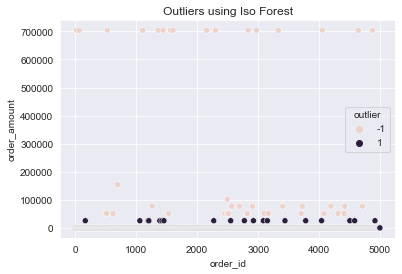

In [71]:
outlier_ax = sns.scatterplot(x='order_id', y='order_amount', hue='outlier', data=outlier_df)
outlier_ax.set_title('Outliers using Iso Forest')

In [72]:
only_outlier_df = outlier_df.loc[outlier_df['outlier'] == -1]
only_outlier_df

,order_id,shop_id,user_id,order_amount,total_items,payment_method,cash,credit_card,debit,day,month,year,weekday,year_day,hours_time,outlier,score
15,16,42,607,704000,2000,credit_card,0,1,0,7,3,2017,1,66,4.000000,-1,-0.111370
60,61,42,607,704000,2000,credit_card,0,1,0,4,3,2017,5,63,4.000000,-1,-0.111370
490,491,78,936,51450,2,debit,0,0,1,26,3,2017,6,85,17.133333,-1,-0.044865
493,494,78,983,51450,2,cash,1,0,0,16,3,2017,3,75,21.650000,-1,-0.044865
511,512,78,967,51450,2,cash,1,0,0,9,3,2017,3,68,7.383333,-1,-0.044865
520,521,42,607,704000,2000,credit_card,0,1,0,2,3,2017,3,61,4.000000,-1,-0.111370
617,618,78,760,51450,2,cash,1,0,0,18,3,2017,5,77,11.300000,-1,-0.044865
691,692,78,878,154350,6,debit,0,0,1,27,3,2017,0,86,22.850000,-1,-0.075975
1104,1105,42,607,704000,2000,credit_card,0,1,0,24,3,2017,4,83,4.000000,-1,-0.111370
1259,1260,78,775,77175,3,credit_card,0,1,0,27,3,2017,0,86,9.450000,-1,-0.059505
